# Setup

In [1]:
#python >=3.5
import sys
assert sys.version_info >= (3,5)

#scikit-learn >=0.20
import sklearn
assert sklearn.__version__ >= "0.20"

#common imports
import numpy as np
import os

#figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize = 14)
mpl.rc("xtick", labelsize = 12)
mpl.rc("ytick", labelsize = 12)


#where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "AI_Human"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id+"."+fig_extension)
    print("saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)   
    
#where to save the word embedding model
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "model")
os.makedirs(MODEL_PATH, exist_ok=True)    

In [2]:
import pandas as pd
texts = pd.read_csv("AI_Human.csv")

# Data overview

In [3]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [4]:
texts.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [5]:
texts.iloc[0,0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

# Splitting the data

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

x = texts['text']
y = texts['generated']

#splitting the data twice because it's too big to test methods on
#first split 96% validation 4%subset
StratifiedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.04, random_state=42)
split_index = list(StratifiedSplit.split(x,y))
validation_index,subset_index = split_index[0]

x_validation,x_subset = x[validation_index], x[subset_index]
y_validation,y_subset = y[validation_index], y[subset_index]

#second split 80% train 20% test
StratifiedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split_index = list(StratifiedSplit.split(x_subset,y_subset))

train_index,test_index = split_index[0]

x_train,x_test = x[train_index], x[test_index]
y_train,y_test = y[train_index], y[test_index]
len(x_train)

15592

# Word vectorization

In [7]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin

#word tokenizer
class WordFilter(BaseEstimator, TransformerMixin):
    def __init__(self,words_to_remove):
        self.words_to_remove = words_to_remove
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.remove_words(text) for text in X]
    
    def remove_words(self,text):
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word.lower() not in self.words_to_remove]         
        return ' '.join(filtered_text)

#downloading stop words and 'punkt' :abbreviation words, collocations, and words that start sentences
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punc = set(string.punctuation)
tags = {'\n', '\''}
text_filter = stop_words|punc|tags

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


vectorizer_pipeline = Pipeline([
    ("word_filter",WordFilter(words_to_remove=text_filter)),
    ("count_vectorizer",CountVectorizer()),
    ("tf-id",TfidfTransformer()),
    ("svc",SVC(kernel='linear', C=1.0, verbose =True))
])

In [18]:
vectorizer_pipeline.fit(x_train,y_train)

Pipeline(steps=[('word_filter',
                 WordFilter(words_to_remove={'\n', '!', '"', '#', '$', '%', '&',
                                             "'", '(', ')', '*', '+', ',', '-',
                                             '.', '/', ':', ';', '<', '=', '>',
                                             '?', '@', '[', '\\', ']', '^', '_',
                                             '`', 'a', ...})),
                ('count_vectorizer', CountVectorizer()),
                ('tf-id', TfidfTransformer()), ('svc', SVC(kernel='linear'))])

In [36]:
y_pred = vectorizer_pipeline.predict(x_test)
len(y_pred)

7796

In [ ]:
accuracy = accuracy_score(y_test,y_pred)
my_list = y_pred.tolist()
frequency = {item: my_list.count(item) for item in my_list}
accuracy

0.9949974345818369

# Random search for word vectorization

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, expon

param_dist = {
    'svc__C': reciprocal(1, 20000),  # specify a continuous distribution
    'svc__gamma': expon(scale=1),     # specify a continuous distribution
    'svc__kernel': ['linear', 'rbf'],   # specify a discrete distribution
}

random_search = RandomizedSearchCV(vectorizer_pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy',verbose=2)
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END svc__C=8.726728863398852, svc__gamma=0.731251388782287, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=8.726728863398852, svc__gamma=0.731251388782287, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=8.726728863398852, svc__gamma=0.731251388782287, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=8.726728863398852, svc__gamma=0.731251388782287, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=8.726728863398852, svc__gamma=0.731251388782287, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=15805.16646233074, svc__gamma=0.15813763277311954, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=15805.16646233074, svc__gamma=0.15813763277311954, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=15805.16646233074, svc__gamma=0.15813763277311954, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=15805.16646233074, svc__gamma=0.15813763277311954, svc__kernel=rbf; total time= 1.4min
[CV] E

[CV] END svc__C=17566.9502268849, svc__gamma=0.22267632566630266, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=7183.212976608682, svc__gamma=0.1342610478162766, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=7183.212976608682, svc__gamma=0.1342610478162766, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=7183.212976608682, svc__gamma=0.1342610478162766, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=7183.212976608682, svc__gamma=0.1342610478162766, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=7183.212976608682, svc__gamma=0.1342610478162766, svc__kernel=rbf; total time= 1.4min
[CV] END svc__C=855.0886273605761, svc__gamma=2.0060387699119175, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=855.0886273605761, svc__gamma=2.0060387699119175, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=855.0886273605761, svc__gamma=2.0060387699119175, svc__kernel=linear; total time= 1.3min
[CV] END svc__C=855.0886273605761, svc__gamma=2.0060387699119175, svc__ke

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('word_filter',
                                              WordFilter(words_to_remove={'\n',
                                                                          '!',
                                                                          '"',
                                                                          '#',
                                                                          '$',
                                                                          '%',
                                                                          '&',
                                                                          "'",
                                                                          '(',
                                                                          ')',
                                                                          '*',
                                            

In [3]:
print(random_search.best_score_)
print(random_search.best_params_)
#best params{'svc__C': 15805.16646233074,
# 'svc__gamma': 0.15813763277311954,
# 'svc__kernel': 'rbf'}

NameError: name 'random_search' is not defined

In [20]:
#trying the best parameters
vectorizer_pipeline = Pipeline([
    ("word_filter",WordFilter(words_to_remove=text_filter)),
    ("count_vectorizer",CountVectorizer()),
    ("tf-id",TfidfTransformer()),
    ("svc",SVC(kernel='rbf', C=15805.16646233074, gamma=0.15813763277311954))
])
vectorizer_pipeline.fit(x_train,y_train)

Pipeline(steps=[('word_filter',
                 WordFilter(words_to_remove={'\n', '!', '"', '#', '$', '%', '&',
                                             "'", '(', ')', '*', '+', ',', '-',
                                             '.', '/', ':', ';', '<', '=', '>',
                                             '?', '@', '[', '\\', ']', '^', '_',
                                             '`', 'a', ...})),
                ('count_vectorizer', CountVectorizer()),
                ('tf-id', TfidfTransformer()),
                ('svc', SVC(C=15805.16646233074, gamma=0.15813763277311954))])

In [21]:
y_pred = vectorizer_pipeline.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
my_list = y_pred.tolist()
frequency = {item: my_list.count(item) for item in my_list}
accuracy

0.995638789122627

# Document embeddings

In [9]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_x_train = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(x_train)]
MODEL_PATH = os.path.join(MODEL_PATH, "model")
doc2vec_model = Doc2Vec(tagged_x_train, vector_size=100, window=5, min_count=1, workers=4)
doc2vec_model.save(MODEL_PATH)

In [10]:
from gensim.models import Doc2Vec
class DocEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self, doc2vec_model):
        self.doc2vec_model = doc2vec_model
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embedded_docs = []
        for doc in X:            
            embedded_doc = self.doc2vec_model.infer_vector(doc.split())
            embedded_docs.append(embedded_doc)
        return embedded_docs

doc2vec_model = Doc2Vec.load(MODEL_PATH)
    
    
embedding_pipeline = Pipeline([
    ("word_filter",WordFilter(words_to_remove=text_filter)),
    ("doc_embeddings", DocEmbeddings(doc2vec_model)),
    ("svc",SVC(kernel='linear', C=1, verbose =True))
])    

In [20]:
embedding_pipeline.fit(x_train,y_train)

Pipeline(steps=[('word_filter',
                 WordFilter(words_to_remove={'\n', '!', '"', '#', '$', '%', '&',
                                             "'", '(', ')', '*', '+', ',', '-',
                                             '.', '/', ':', ';', '<', '=', '>',
                                             '?', '@', '[', '\\', ']', '^', '_',
                                             '`', 'a', ...})),
                ('doc_embeddings',
                 DocEmbeddings(doc2vec_model=<gensim.models.doc2vec.Doc2Vec object at 0x000001E0CD27E090>)),
                ('svc', SVC(C=1, kernel='linear'))])

In [19]:
y_pred = embedding_pipeline.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
my_list = y_pred.tolist()
frequency = {item: my_list.count(item) for item in my_list}
accuracy

0.9853771164699846

# Comparing embeddings vs vectorization

In [21]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Evaluate the first pipeline
y_pred1 = vectorizer_pipeline.predict(x_test)
print("Pipeline 1 Metrics:")
print(classification_report(y_test, y_pred1))
roc_auc1 = roc_auc_score(y_test, y_pred1)

# Evaluate the second pipeline
y_pred2 = embedding_pipeline.predict(x_test)
print("Pipeline 2 Metrics:")
print(classification_report(y_test, y_pred2))
roc_auc2 = roc_auc_score(y_test, y_pred2)

print("ROC-AUC Score for Pipeline 1:", roc_auc1)
print("ROC-AUC Score for Pipeline 2:", roc_auc2)

# Perform cross-validation for Pipeline 1
cv_scores1 = cross_val_score(vectorizer_pipeline, x_train, y_train, cv=5, scoring='accuracy')

# Perform cross-validation for Pipeline 2
cv_scores2 = cross_val_score(embedding_pipeline, x_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores for Pipeline 1:", cv_scores1)
print("Average Accuracy for Pipeline 1:", cv_scores1.mean())

print("Cross-Validation Scores for Pipeline 2:", cv_scores2)
print("Average Accuracy for Pipeline 2:", cv_scores2.mean())



Pipeline 1 Metrics:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3199
         1.0       0.99      0.98      0.98       699

    accuracy                           0.99      3898
   macro avg       0.99      0.99      0.99      3898
weighted avg       0.99      0.99      0.99      3898

Pipeline 2 Metrics:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3199
         1.0       0.94      0.93      0.94       699

    accuracy                           0.98      3898
   macro avg       0.96      0.96      0.96      3898
weighted avg       0.98      0.98      0.98      3898

ROC-AUC Score for Pipeline 1: 0.9878636966755974
ROC-AUC Score for Pipeline 2: 0.9594132823159597
Cross-Validation Scores for Pipeline 1: [0.99551138 0.99422892 0.99326491 0.99422707 0.99615138]
Average Accuracy for Pipeline 1: 0.9946767325015152
Cross-Validation Scores for Pipeline 2: [0.97435075 0.97403

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt



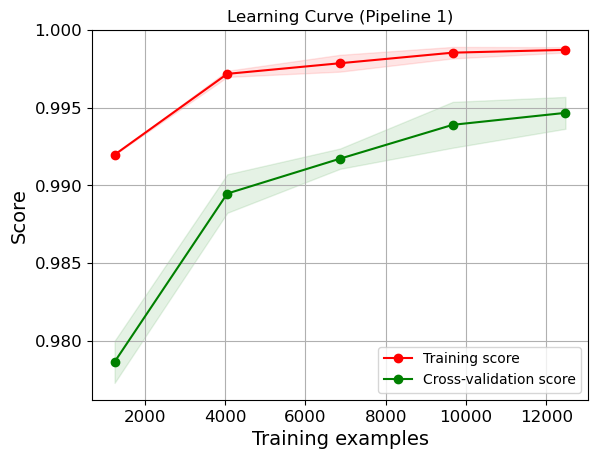

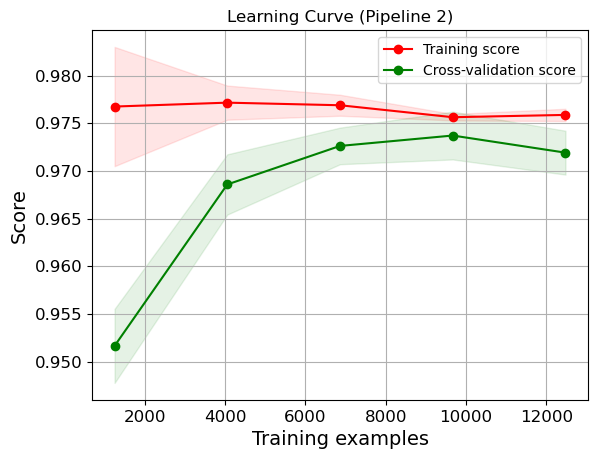

In [13]:
# Plot learning curves for both pipelines
plot_learning_curve(vectorizer_pipeline, "Learning Curve (Pipeline 1)", x_train, y_train, cv=5)
plt.show()

plot_learning_curve(embedding_pipeline, "Learning Curve (Pipeline 2)", x_train, y_train, cv=5)
plt.show()

# Training vectorization on 80% of the whole data

In [10]:
StratifiedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split_index = list(StratifiedSplit.split(x,y))
final_train_index,final_test_index = split_index[0]

x_final_train,x_final_test = x[final_train_index], x[final_test_index]
y_final_train,y_final_test = y[final_train_index], y[final_test_index]

In [11]:
vectorizer_pipeline.fit(x_final_train,y_final_train)

[LibSVM]

Pipeline(steps=[('word_filter',
                 WordFilter(words_to_remove={'\n', '!', '"', '#', '$', '%', '&',
                                             "'", '(', ')', '*', '+', ',', '-',
                                             '.', '/', ':', ';', '<', '=', '>',
                                             '?', '@', '[', '\\', ']', '^', '_',
                                             '`', 'a', ...})),
                ('count_vectorizer', CountVectorizer()),
                ('tf-id', TfidfTransformer()),
                ('svc', SVC(kernel='linear', verbose=True))])

In [12]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Evaluate the vectorizer pipeline

y_pred = vectorizer_pipeline.predict(x_final_test)
print("vectorizer_pipeline:")
print(classification_report(y_final_test, y_pred))
roc_auc = roc_auc_score(y_final_test, y_pred)

print("ROC-AUC Score for Pipeline 1:", roc_auc)


vectorizer_pipeline:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     61159
         1.0       1.00      0.99      1.00     36288

    accuracy                           1.00     97447
   macro avg       1.00      1.00      1.00     97447
weighted avg       1.00      1.00      1.00     97447

ROC-AUC Score for Pipeline 1: 0.9967885582691867
